# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [2]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [0]:
!pip install pandas scikit-learn gensim matplotlib

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Домашка

1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).
Подсказка: используйте functional api, сделайте два Embedding слоя и к их выходам примените слой Concatenate([emb1, emb2)) или Average([emb1, emb2))



Бонусный балл можно получить за эксперименты с параметрами в Embbeding, Dense (поизучайте другие существующие параметры и попробуйте комбинировать несколько слоев с разным активациями) слоях, а также за эксперименты с улучшением нормализации.

Лучше делать задание на второй задаче, так как в Авито в любом случае разница будет в несколько десятых процентов.

# Преобразование эмбедингов

In [0]:
from string import punctuation
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
quora = pd.read_csv('quora.csv')

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=22)

In [0]:
class My_Callbacks(tf.keras.callbacks.Callback):
  f1_w_train = []
  f1_m_train = []
  f1_w_valid = []
  f1_m_valid = []

  def clear(self):
    self.f1_w_train = []
    self.f1_m_train = []
    self.f1_w_valid = []
    self.f1_m_valid = []

  def show_scores(self):
    print("weighted f1 on train: ", self.f1_w_train)
    print("macro f1 on train: ", self.f1_m_train)
    print("weighted f1 on valid: ", self.f1_w_valid)
    print("macro f1 on valid: ", self.f1_m_valid)

  def on_epoch_end(self, epoch, logs=None):
    preds1 = self.model.predict(X_train).reshape(-1)
    report1 = classification_report(y_train, (preds1 > 0.5).astype(int), output_dict=True, zero_division=0)
    preds2 = self.model.predict(X_valid).reshape(-1)
    report2 = classification_report(y_valid, (preds2 > 0.5).astype(int), output_dict=True, zero_division=0)

    self.f1_w_train.append(report1["weighted avg"]["f1-score"])
    self.f1_m_train.append(report1["macro avg"]["f1-score"])
    self.f1_w_valid.append(report2["weighted avg"]["f1-score"])
    self.f1_m_valid.append(report2["macro avg"]["f1-score"])

In [0]:
def get_model(emb_transform, dense_layers, activation, batch_size, epochs, verbose=1):
  inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
  embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
  if emb_transform == 'mean':
    transformed = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
  elif emb_transform == 'sum':
    transformed = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
  else:
    transformed = tf.keras.layers.Flatten()(embeddings)
    
  dense = dense_layers[0](transformed)
  for i in range(1, len(dense_layers)):
    dense = dense_layers[i](dense)
  outputs = tf.keras.layers.Dense(1, activation=activation)(dense)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  callbacks = My_Callbacks()
  callbacks.clear()
  model.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[callbacks],
            verbose=verbose)
  callbacks.show_scores()

  plot_x = [e for e in range(1, epochs+1)]

  fig, (ax1, ax2) = plt.subplots(2)
  ax1.plot(plot_x, callbacks.f1_w_train, label='weighted f1 train')
  ax2.plot(plot_x, callbacks.f1_m_train, label='macro f1 train')
  ax1.plot(plot_x, callbacks.f1_w_valid, label='weighted f1 valid')
  ax2.plot(plot_x, callbacks.f1_m_valid, label='macro f1 valid')
  ax1.set_ylabel('f1')
  ax1.set_xlabel('epoch')
  ax2.set_ylabel('f1')
  ax2.set_xlabel('epoch')
  fig.set_size_inches(10, 10, forward=True)
  plt.show()

In [0]:
batch_size = 20000
epochs = 5

In [0]:
activations = ['relu',
               'softmax',
               'sigmoid',
               'exponential',
               'linear']
units = [50, 75, 100]

## Конкатенация

activation - relu
weighted f1 on train:  [0.9325579871016193, 0.9484957287944086, 0.9528186936437478, 0.9546124413579784, 0.9553867835040593]
macro f1 on train:  [0.6580687047240327, 0.7606866293839651, 0.785638159222919, 0.7941160904795546, 0.7964294564303953]
weighted f1 on valid:  [0.9346182588908462, 0.94921118288534, 0.9519775193921367, 0.9526056514822344, 0.9525289461068682]
macro f1 on valid:  [0.6661576802043561, 0.7616065300159722, 0.7793508400648528, 0.7827332528503392, 0.7807201607787713]


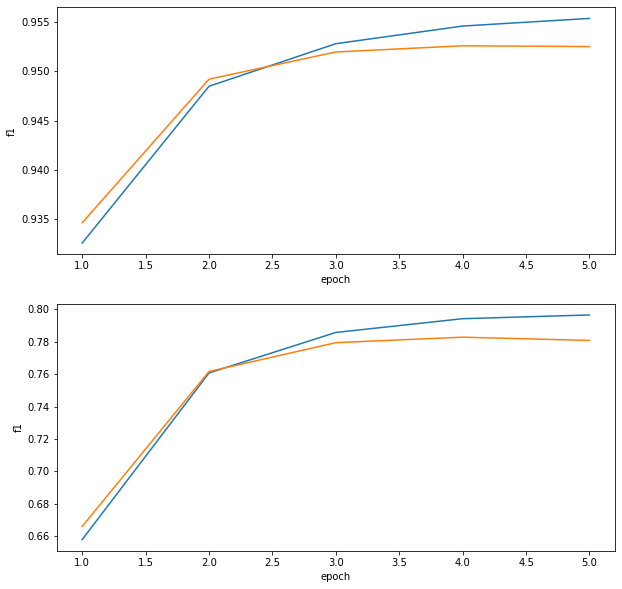

activation - softmax
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159]
macro f1 on valid:  [0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896]


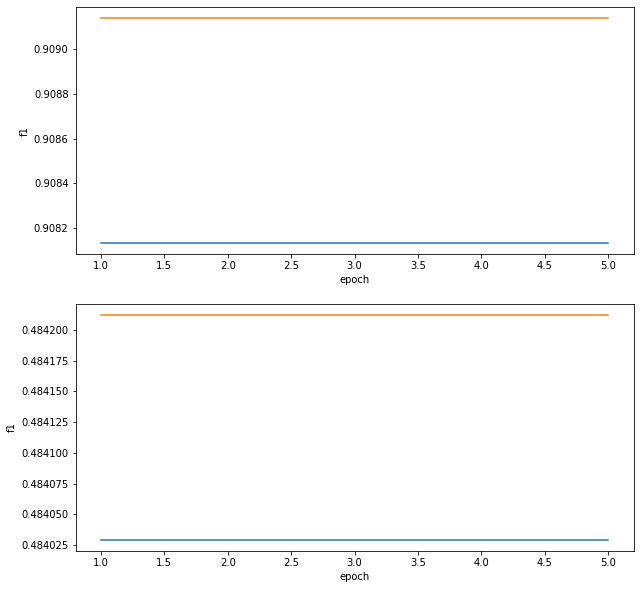

activation - sigmoid
weighted f1 on train:  [0.923902357055947, 0.945114125773513, 0.9490645934619428, 0.9508343101894324, 0.9544956565514864]
macro f1 on train:  [0.5964652396175179, 0.7379883432141214, 0.7597718870045485, 0.7681763573982427, 0.7915303067904582]
weighted f1 on valid:  [0.9248147785236838, 0.94587100902436, 0.9490188805832925, 0.9498966661146194, 0.9519730107010852]
macro f1 on valid:  [0.5966449652945864, 0.7396051471367964, 0.7578014130043559, 0.7620930536456586, 0.777378338984601]


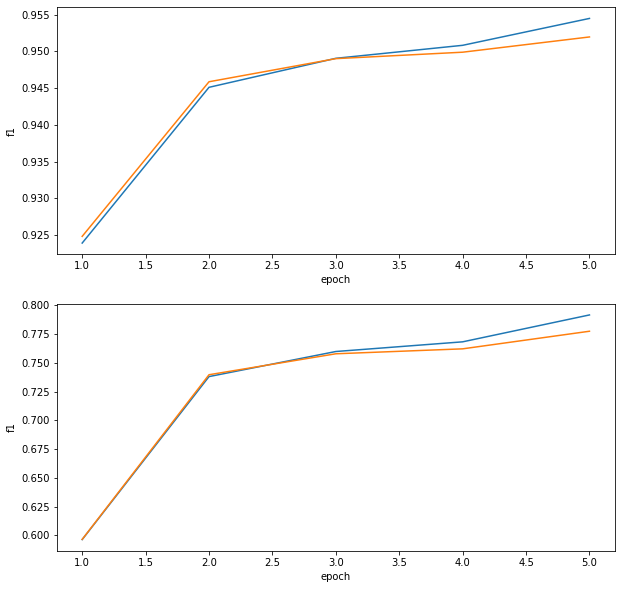

activation - exponential
weighted f1 on train:  [0.9416604708377411, 0.9498534211789059, 0.9527264476232304, 0.9561950600171831, 0.9589410313287026]
macro f1 on train:  [0.7187922428326676, 0.7635906747753569, 0.7788030437831439, 0.7970965052091827, 0.8097355027500022]
weighted f1 on valid:  [0.9433908568160877, 0.9494596863514149, 0.9504785200664843, 0.9514806983365951, 0.9507317431972557]
macro f1 on valid:  [0.7255092849395114, 0.7597728859334236, 0.7659014620649275, 0.7724027755837894, 0.7683785359607755]


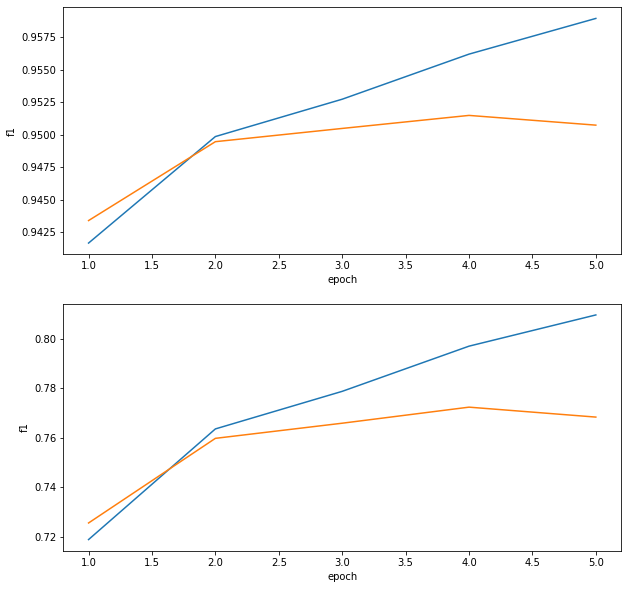

activation - linear
weighted f1 on train:  [0.9372447756967283, 0.9475702439446948, 0.9497757482584159, 0.9543412289918465, 0.956281082324685]
macro f1 on train:  [0.6898737252944922, 0.7494928465074084, 0.7602636015250717, 0.7879874282039949, 0.7969836537056361]
weighted f1 on valid:  [0.9390167219544723, 0.9475348538590348, 0.9483643909304393, 0.9506931511974509, 0.950171784208396]
macro f1 on valid:  [0.6966707605497642, 0.747282570525416, 0.7511011229103437, 0.7682410286379979, 0.7655831428538049]


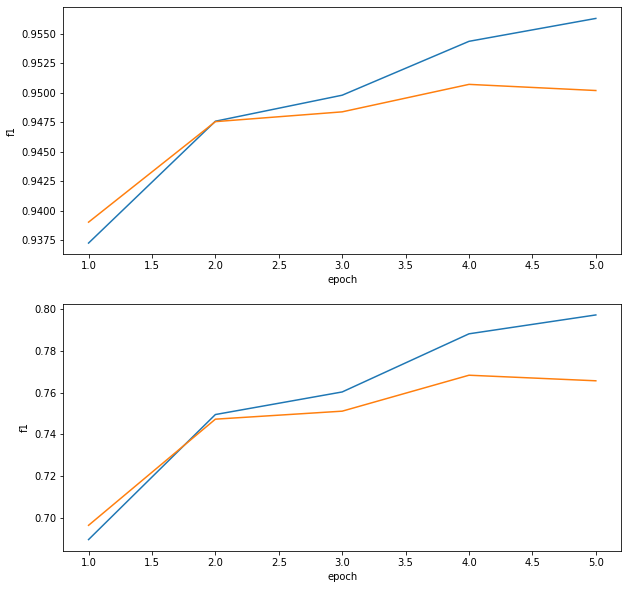

In [38]:
for a in activations:
  print("activation - %s" %a)
  get_model("", [tf.keras.layers.Dense(50, activation=a)], "sigmoid", batch_size, epochs, 0)

Лучше всего себя показала функция "relu", возьмем 3 эпоху за основу (смотреть будем на одну эпоху дальше);  
результаты:  
- weighted f1 on train: 0.9528186936437478  
- macro f1 on train: 0.785638159222919  
- weighted f1 on valid: 0.9519775193921367  
- macro f1 on valid: 0.7793508400648528  

units - 50
weighted f1 on train:  [0.9257323956877149, 0.9491707070780964, 0.9511920021108172, 0.955534063518]
macro f1 on train:  [0.6083810651245042, 0.7663769893792274, 0.7731358973488468, 0.8007134626876133]
weighted f1 on valid:  [0.9271470192681686, 0.9495200607521465, 0.950966536536319, 0.9534102322038355]
macro f1 on valid:  [0.6119266475517714, 0.7658476375946643, 0.770381702824835, 0.7889310214603329]


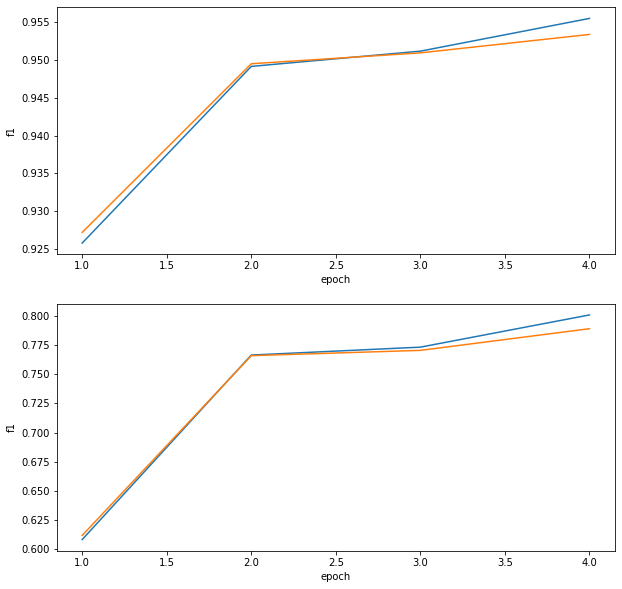

units - 75
weighted f1 on train:  [0.9081315279850083, 0.9466433208464641, 0.9518600695164363, 0.9551845220806274]
macro f1 on train:  [0.48402934609993187, 0.748607726695792, 0.7817253588668687, 0.7991920162251189]
weighted f1 on valid:  [0.9091386834586159, 0.9481569864921796, 0.9512167460766965, 0.9530076736896771]
macro f1 on valid:  [0.4842121058949896, 0.7535179493786061, 0.7766413672374908, 0.7867047544318955]


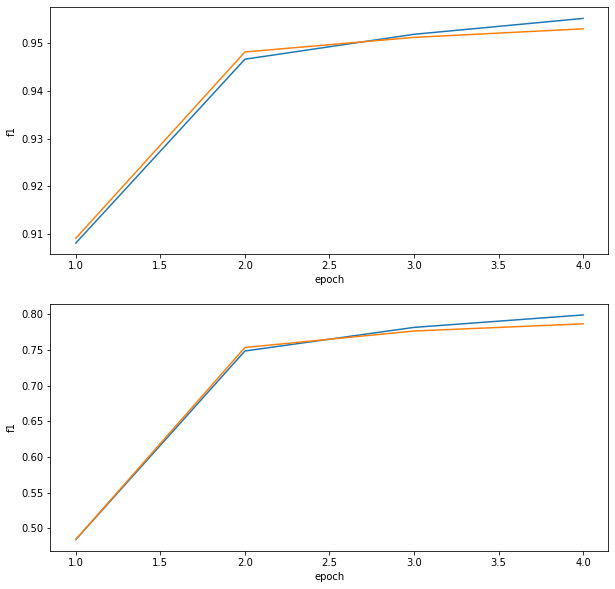

units - 100
weighted f1 on train:  [0.9081315279850083, 0.9480226269824126, 0.9534601365715311, 0.9549179126987375]
macro f1 on train:  [0.48402934609993187, 0.7584836184790267, 0.7901581140328836, 0.795856816924279]
weighted f1 on valid:  [0.9091386834586159, 0.9492581190026611, 0.9524727069095787, 0.9530029465933987]
macro f1 on valid:  [0.4842121058949896, 0.7620069713592152, 0.7834709748972535, 0.7849122839038296]


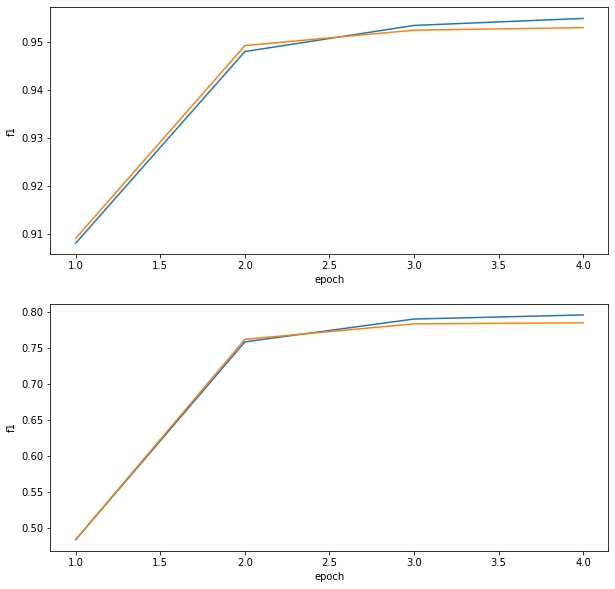

In [40]:
epochs = 4
for u in units:
  print("units - %d" %u)
  get_model("", [tf.keras.layers.Dense(u, activation="relu")], "sigmoid", batch_size, epochs, 0)

С ростом количества юнитов графики становятся ближе; возьмем тогда units = 100

Попробуем добавить еще один слой:

activation - relu
weighted f1 on train:  [0.9205920858906975, 0.9495722153363768, 0.9539742209007894, 0.9536525545748795]
macro f1 on train:  [0.5725342675572483, 0.7682419697745462, 0.7927946948550368, 0.7860900069403172]
weighted f1 on valid:  [0.9216728828477637, 0.9506330888495506, 0.9536432733932722, 0.9520098627282289]
macro f1 on valid:  [0.5734236476386935, 0.7708676255193635, 0.7890493173312922, 0.7758317277349938]


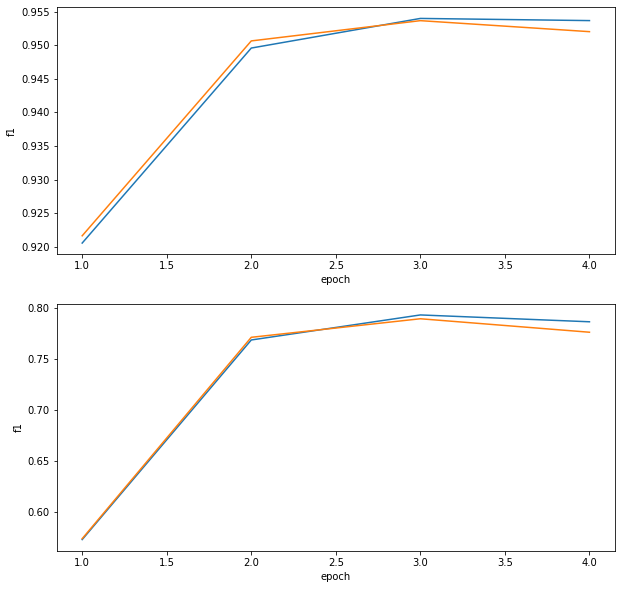

activation - softmax
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159]
macro f1 on valid:  [0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896]


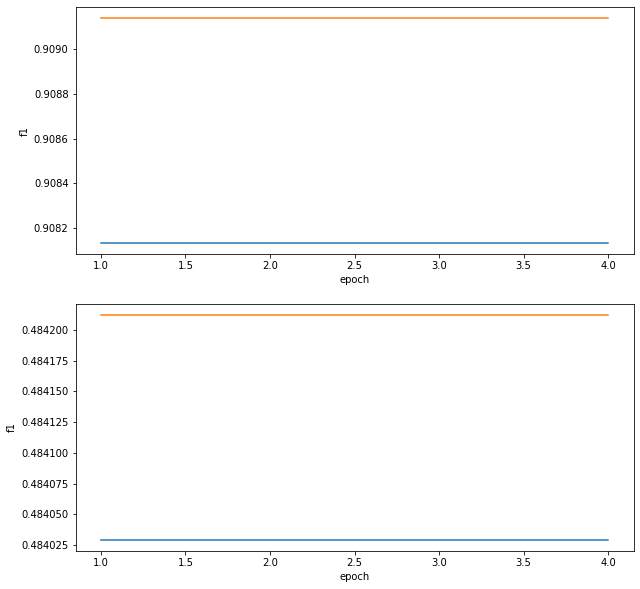

activation - sigmoid
weighted f1 on train:  [0.9081315279850083, 0.940495072858876, 0.9496081332495491, 0.9510145024299939]
macro f1 on train:  [0.48402934609993187, 0.7137622900907362, 0.7698797567558748, 0.7742132146997662]
weighted f1 on valid:  [0.9091386834586159, 0.9425534825726223, 0.9503315825611874, 0.9516398291522611]
macro f1 on valid:  [0.4842121058949896, 0.722064679649326, 0.770797656369222, 0.7749789523161839]


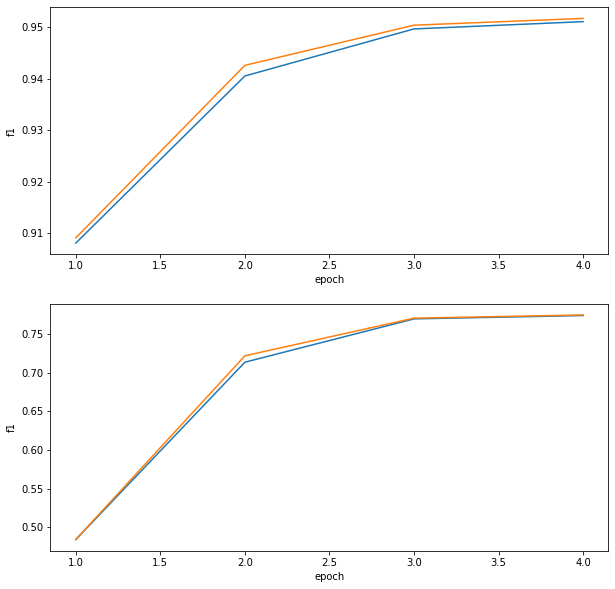

activation - exponential
weighted f1 on train:  [0.9081319305350241, 0.9527501171594989, 0.947317268763643, 0.9599425623024331]
macro f1 on train:  [0.4840295606569811, 0.786177912881753, 0.7433678168579503, 0.8320734486548587]
weighted f1 on valid:  [0.9091386834586159, 0.9525844865810288, 0.9468094131285895, 0.9530731625548595]
macro f1 on valid:  [0.4842121058949896, 0.7832637293748148, 0.7389386055175915, 0.8004508470449511]


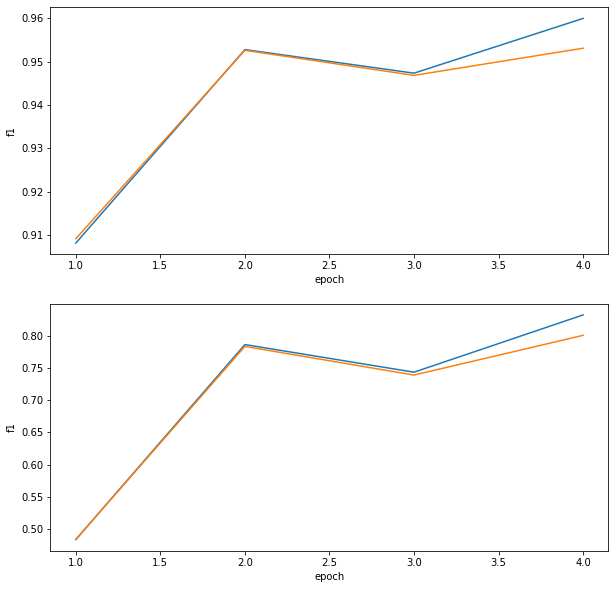

activation - linear
weighted f1 on train:  [0.9081315279850083, 0.949593119166204, 0.9543883839524342, 0.9574468135847528]
macro f1 on train:  [0.48402934609993187, 0.7658363359208367, 0.7935315979007181, 0.810592746052343]
weighted f1 on valid:  [0.9091386834586159, 0.9503259058096304, 0.9526867068268727, 0.953674994688548]
macro f1 on valid:  [0.4842121058949896, 0.7668976467081801, 0.7835581499730593, 0.7916021409124716]


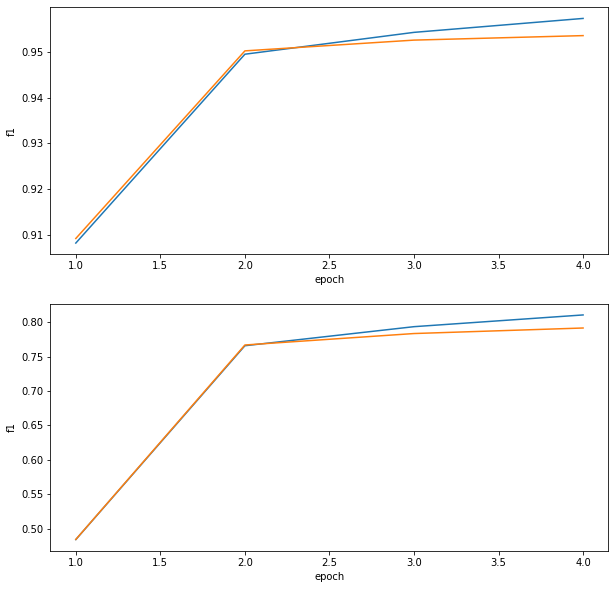

In [41]:
for a in activations:
  print("activation - %s" %a)
  first_layer = tf.keras.layers.Dense(50, activation="relu")
  get_model("", [first_layer, tf.keras.layers.Dense(100, activation=a)], "sigmoid", batch_size, epochs, 0)

Добавление нового слоя нам ничего и не дало

А что насчет функции активации для финального слоя?

activation - relu
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159]
macro f1 on valid:  [0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896]


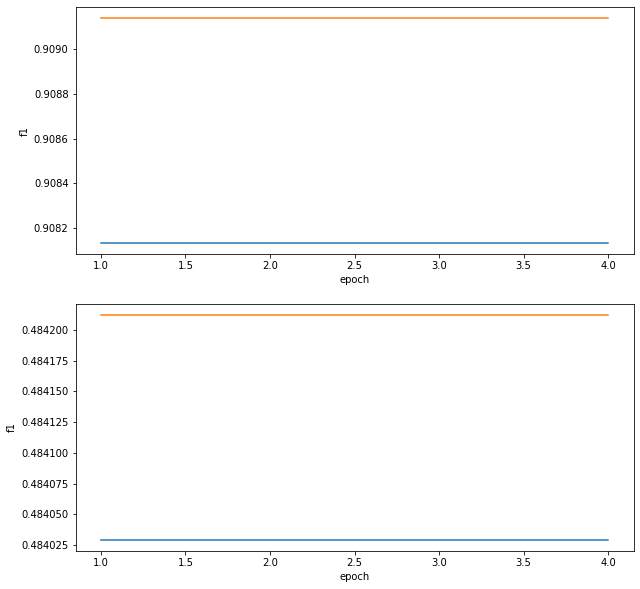

activation - softmax
weighted f1 on train:  [0.007217530397734457, 0.007217530397734457, 0.007217530397734457, 0.007217530397734457]
macro f1 on train:  [0.058295708876639596, 0.058295708876639596, 0.058295708876639596, 0.058295708876639596]
weighted f1 on valid:  [0.007063033616566146, 0.007063033616566146, 0.007063033616566146, 0.007063033616566146]
macro f1 on valid:  [0.05768703556741937, 0.05768703556741937, 0.05768703556741937, 0.05768703556741937]


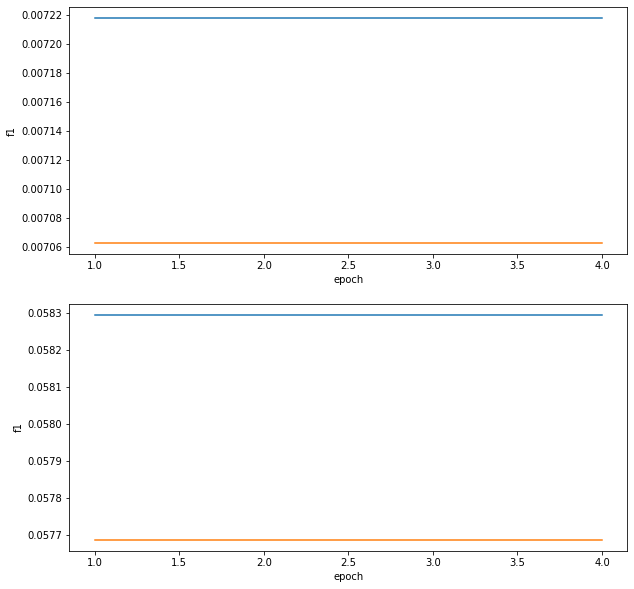

activation - sigmoid
weighted f1 on train:  [0.908312726714963, 0.9477718864933784, 0.9522149617660058, 0.9548223936980189]
macro f1 on train:  [0.4852552613235257, 0.755462677450291, 0.779954140016166, 0.7946857079719001]
weighted f1 on valid:  [0.9092897814138716, 0.9489104524063183, 0.9515143609764225, 0.9525025766821988]
macro f1 on valid:  [0.48522690365555543, 0.7585962147073029, 0.7746769124591522, 0.7816554766225102]


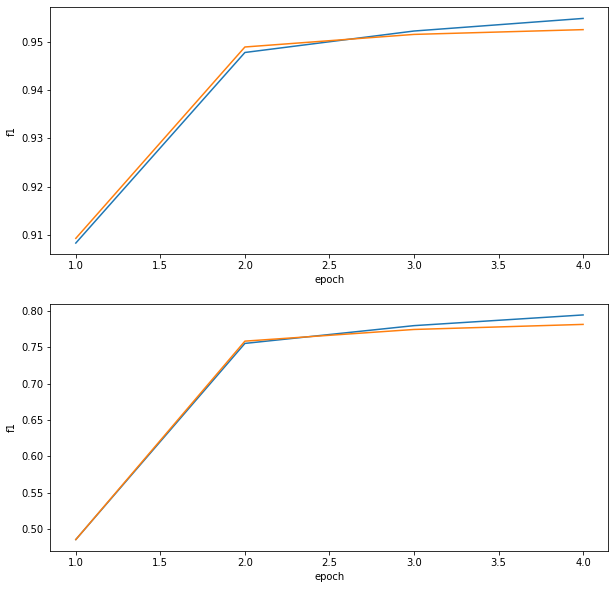

activation - exponential
weighted f1 on train:  [0.9081315279850083, 0.9083139030492751, 0.9243674410114276, 0.9182955532758179]
macro f1 on train:  [0.48402934609993187, 0.4852679871941561, 0.5969635197049948, 0.5537975713071077]
weighted f1 on valid:  [0.9091386834586159, 0.9093275179724376, 0.9257786386458453, 0.919502715942655]
macro f1 on valid:  [0.4842121058949896, 0.4854802911369797, 0.5999702647132542, 0.5562135300767538]


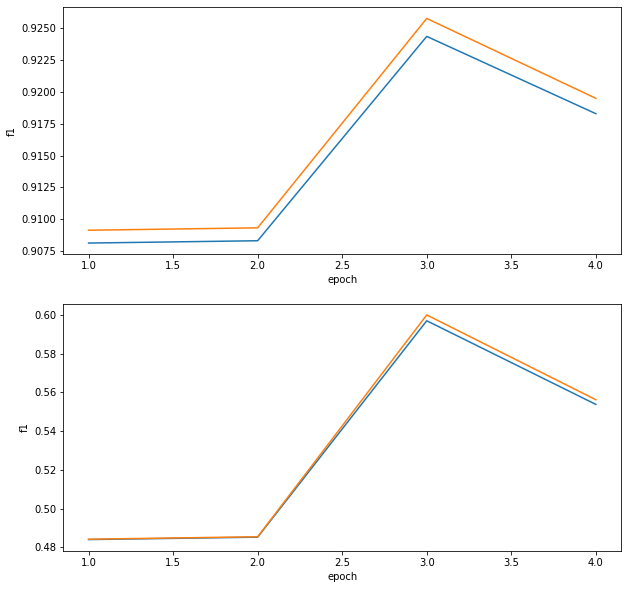

activation - linear
weighted f1 on train:  [0.007219147717855748, 0.007219147717855748, 0.007219147717855748, 0.007219147717855748]
macro f1 on train:  [0.05829661222320272, 0.05829661222320272, 0.05829661222320272, 0.05829661222320272]
weighted f1 on valid:  [0.007063033616566146, 0.007063033616566146, 0.007063033616566146, 0.007063033616566146]
macro f1 on valid:  [0.05768703556741937, 0.05768703556741937, 0.05768703556741937, 0.05768703556741937]


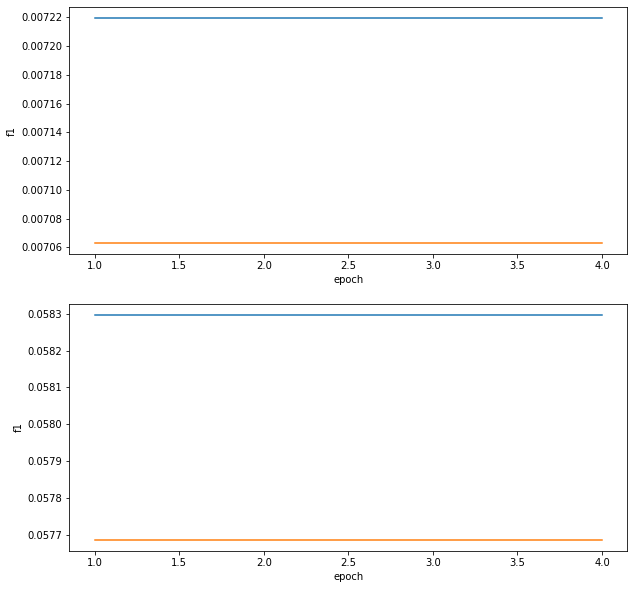

In [42]:
for a in activations:
  print("activation - %s" %a)
  get_model("", [tf.keras.layers.Dense(100, activation="relu")], a, batch_size, epochs, 0)

В итоге, наилучшие значения:
- weighted f1 on train: ~ 0.95
- macro f1 on train: ~0.78  
- weighted f1 on valid: ~ 0.95
- macro f1 on valid: ~ 0.78

## Усреднение

activation - relu
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081335174172278, 0.9127468117869728, 0.9270392996211978, 0.9362109783597635, 0.9399823507206362, 0.9428606553855459, 0.9437018272206642, 0.944932846286841, 0.9474193408065511, 0.9483560704733077, 0.9491262754274097, 0.9507263176531965]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.48404256583511085, 0.5166182632333884, 0.6181686070011675, 0.6812499249827917, 0.7047284959380695, 0.7227304386663409, 0.7268300227702686, 0.7341367859717929, 0.750514246961123, 0.7559914314501448, 0.7603899778532146, 0.771518048906271]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9137392616709218, 0.9281420552942199, 0.9382081484611436, 0.9422249612615761, 0.9451174086401724, 0.9457680719581437, 0.94649033208534, 0.9486689628883147, 0.9493263654188865, 0.9501621802960086, 0.9516880397636214]
macro f1 on valid

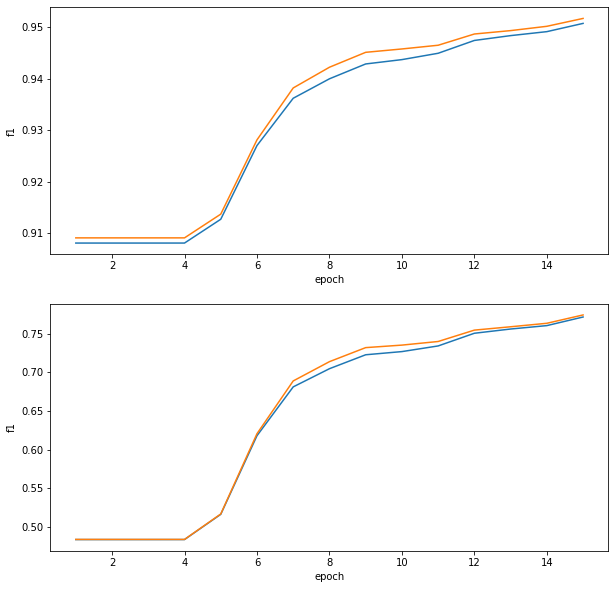

activation - softmax
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159]
macro f1 o

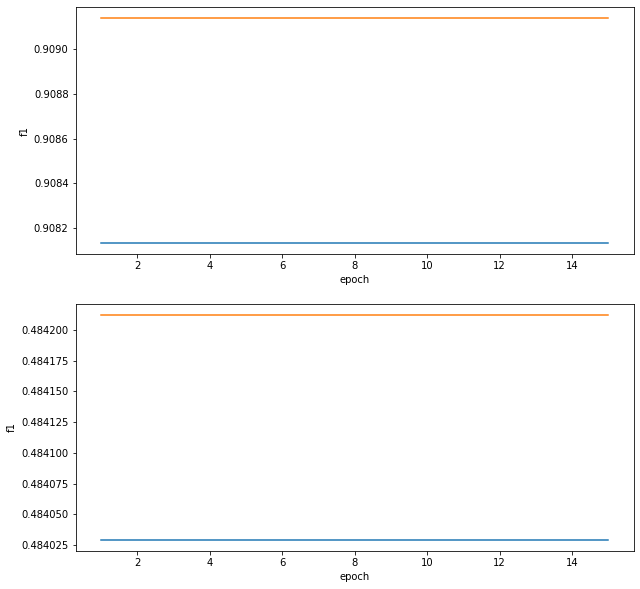

activation - sigmoid
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081315279850083, 0.9081645368547143, 0.9095649968381092, 0.9142519032009443, 0.919383860112473, 0.9240243726744348, 0.9282486353041087, 0.9309546004892265, 0.9334563259890023, 0.9358982897331244]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.48402934609993187, 0.48425360065709383, 0.49407274026875264, 0.527547688113103, 0.5641297700044685, 0.597163557964481, 0.6270815082623662, 0.645535989921003, 0.6622859579389421, 0.6787931900863118]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9110440601070827, 0.915363249657877, 0.9208515676168446, 0.9251342144411452, 0.9296040492558643, 0.9327641848699323, 0.9356347065576696, 0.9381808204690252]
macro f1 on 

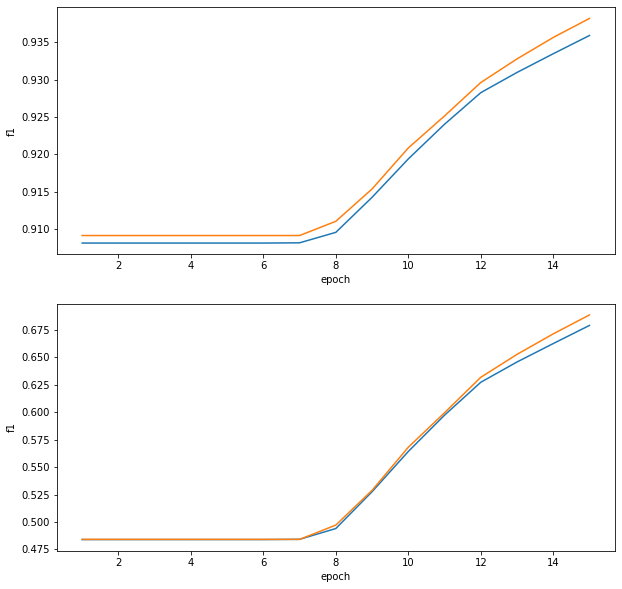

activation - exponential
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081315279850083, 0.9095949884309272, 0.9197288480655162, 0.9295871916248832, 0.9368353339947977, 0.9411612054198958, 0.9438000546846222, 0.9457960343809416, 0.9481104367539634, 0.9479758967081623, 0.9490468566482694, 0.9507058562257963, 0.9522441127474067]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.48402934609993187, 0.4942784829036504, 0.5664816398568074, 0.6361310982667127, 0.685680739606275, 0.7132615672285464, 0.7292814466301574, 0.7411327834127512, 0.7562443103270338, 0.7535142509486523, 0.7600191161191543, 0.7716250714196475, 0.7824665146992436]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9108429120208948, 0.9210458324368402, 0.9309787159993357, 0.9391354388007078, 0.9431706567508397, 0.9458472121647158, 0.9472902659558347, 0.9492335905215163, 0.9488644590432149, 0.9500173661355613, 0.9515001857633907, 0.9525472262965066]
macro 

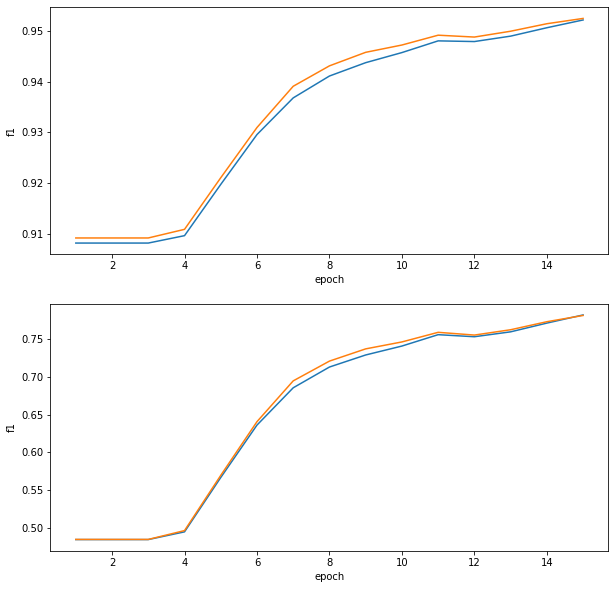

activation - linear
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081315279850083, 0.9083075054500777, 0.915561137261858, 0.927200702548551, 0.9345699953550166, 0.9392010575757974, 0.9409135895681102, 0.9436053766488222, 0.9450079265425186, 0.9460250244731533, 0.946020369218245, 0.9473247678023395, 0.9473202136931308]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.48402934609993187, 0.485240233339347, 0.5366272004457996, 0.6191737281717629, 0.6698087300849915, 0.7001472100338982, 0.7096639850720718, 0.7270829923968445, 0.7354489912224104, 0.7413803927965148, 0.7403751242941632, 0.7487497542003194, 0.7477433002213094]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9092897814138716, 0.9165877606554552, 0.9284672982829066, 0.9366298212274032, 0.9415828521378607, 0.9431313617542768, 0.9457416834899998, 0.946588464585669, 0.9474041376042344, 0.9470799952902968, 0.9484962442452369, 0.9482641548002991]
macro f1 on val

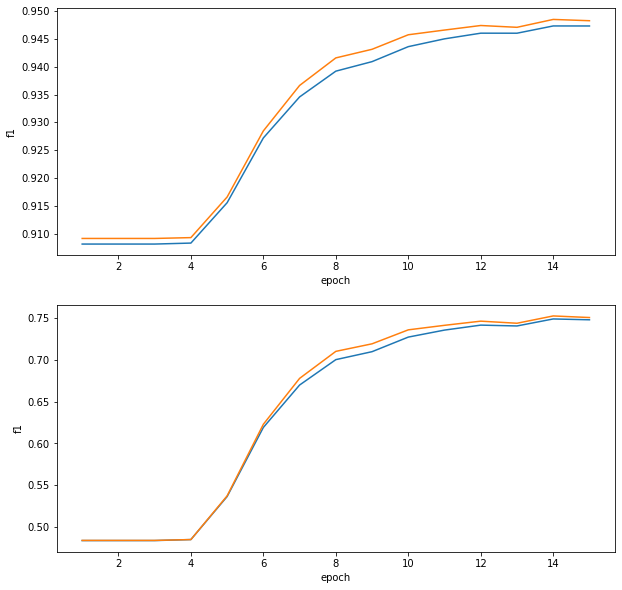

In [45]:
epochs = 15
for a in activations:
  print("activation - %s" %a)
  get_model("mean", [tf.keras.layers.Dense(50, activation=a)], "sigmoid", batch_size, epochs, 0)

Как мы видим, потенциально графики при "exponential" все продолжают расти, так что он вроде как и лучше должен давать результаты, чем конкатенация. Но ждать, пока проходит 15 эпох (а надо больше), грустно, так что больше никак модель вертеть не буду  
Результаты:
- weighted f1 on train: ~0.95
- macro f1 on train: ~0.78
- weighted f1 on valid: ~0.95
- macro f1 on valid: ~0.78

## Сложение

activation - relu
weighted f1 on train:  [0.9318748010531267, 0.9417997491232332, 0.9496539419514761, 0.9514553572439343, 0.9515220089778991, 0.9524656114664198, 0.9562159047441081]
macro f1 on train:  [0.649653005414104, 0.712507074266596, 0.7637106065739195, 0.7736691312595021, 0.7724998794582463, 0.7775134683199687, 0.8128248324054339]
weighted f1 on valid:  [0.9333528373152515, 0.9432654190917409, 0.9501365148358115, 0.9510203888081619, 0.9506068124366253, 0.9511369894202213, 0.9538700844955253]
macro f1 on valid:  [0.6547454196019005, 0.7176904559831568, 0.7641349047756547, 0.7693712891671043, 0.766166295300325, 0.7695996053466064, 0.800360319315917]


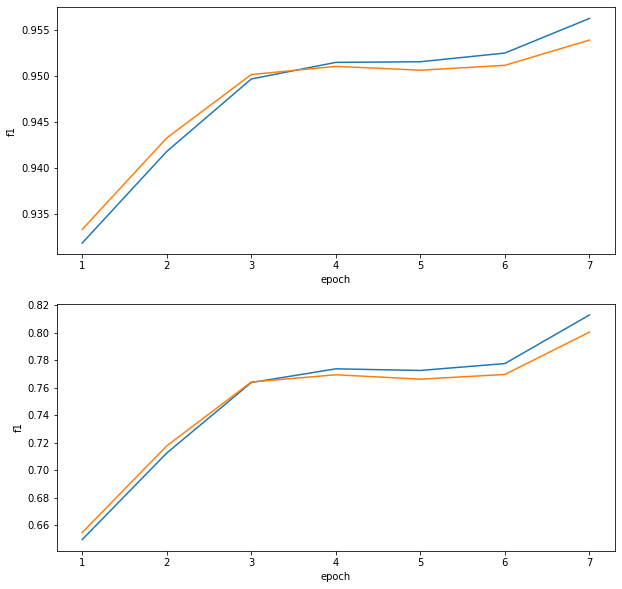

activation - softmax
weighted f1 on train:  [0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241, 0.9081319305350241]
macro f1 on train:  [0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811, 0.4840295606569811]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159, 0.9091386834586159]
macro f1 on valid:  [0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896, 0.4842121058949896]


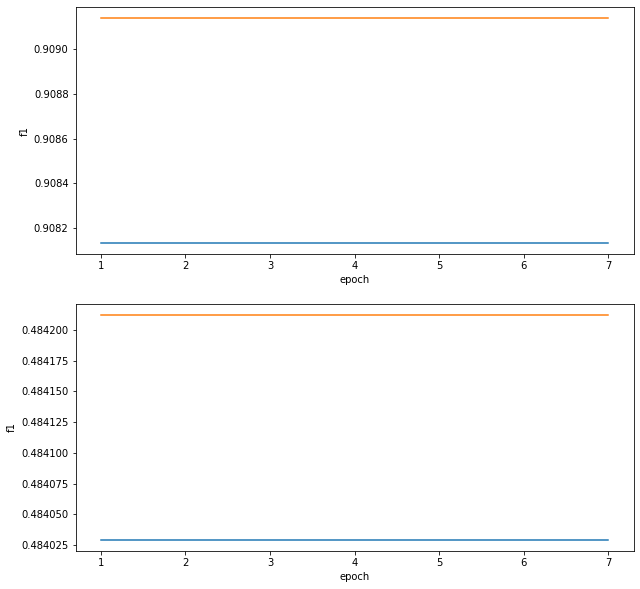

activation - sigmoid
weighted f1 on train:  [0.9081319305350241, 0.9081315279850083, 0.9271035905697864, 0.9445232448472224, 0.951771727788474, 0.9523161602128891, 0.9541607820069588]
macro f1 on train:  [0.4840295606569811, 0.48402934609993187, 0.6145422095384145, 0.7323472110884657, 0.7834945181598805, 0.7848706254602844, 0.7985941188730936]
weighted f1 on valid:  [0.9091386834586159, 0.9091386834586159, 0.9285162629461619, 0.9464771064966739, 0.9528604433553584, 0.9531543351767795, 0.9540468381388506]
macro f1 on valid:  [0.4842121058949896, 0.4842121058949896, 0.6188110602848305, 0.7400167558085425, 0.7863492287213593, 0.7864064070467822, 0.7959272004704022]


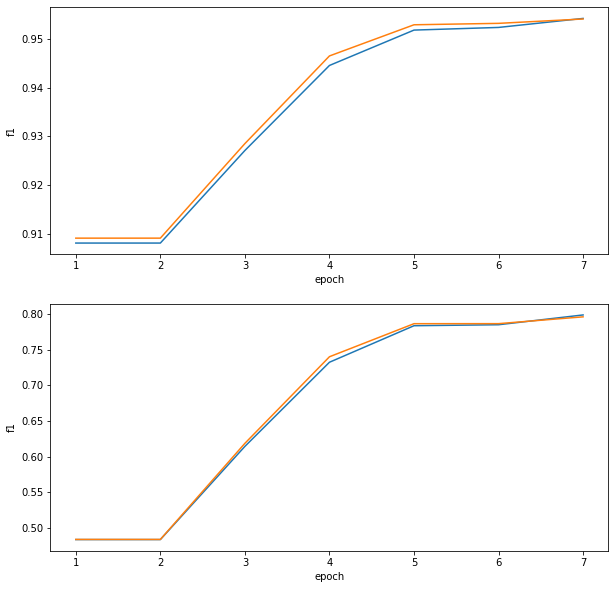

activation - exponential
weighted f1 on train:  [0.918421779708195, 0.9227514274880071, 0.9129216203140375, 0.9358202342507146, 0.9444966005494603, 0.9427568744664625, 0.9523710419760574]
macro f1 on train:  [0.5804926194259848, 0.6036669424462834, 0.5176036849006658, 0.6775817952060088, 0.7323463228640158, 0.7160384836825386, 0.78068927767948]
weighted f1 on valid:  [0.9201249072557155, 0.9239065957253692, 0.9144192619295034, 0.9373321231959616, 0.9450857768131657, 0.9434538071227108, 0.9511893925111218]
macro f1 on valid:  [0.5847461074414387, 0.6060849378578884, 0.5209844125082856, 0.6826710763532582, 0.7328225037347537, 0.7174755250942608, 0.7727978247796383]


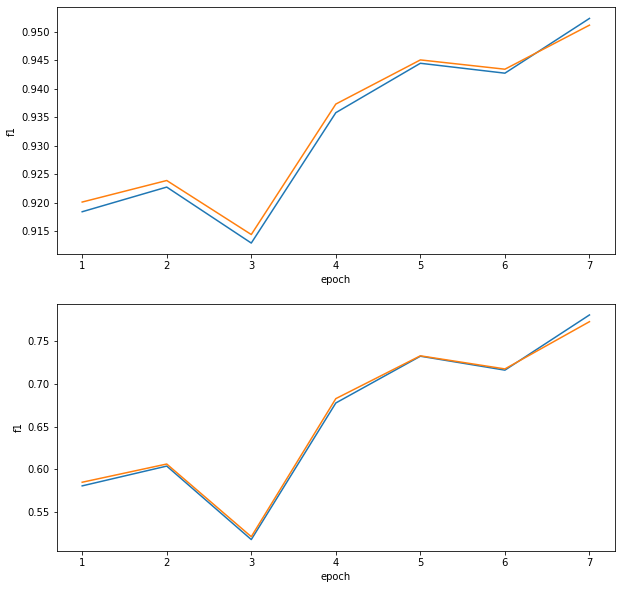

activation - linear
weighted f1 on train:  [0.9339461734590407, 0.9447151261433147, 0.9465717374404753, 0.9464986440116188, 0.9524361684820334, 0.9487238305471121, 0.94998323276814]
macro f1 on train:  [0.6620359397870486, 0.7316262918207862, 0.7412801858054514, 0.7395771460388313, 0.779674594620335, 0.7533410542425383, 0.7616765284677042]
weighted f1 on valid:  [0.9360693807721878, 0.9456977935938321, 0.9468829272231826, 0.9468166295579294, 0.9511080760667632, 0.9485380428509887, 0.9492427780552279]
macro f1 on valid:  [0.6706521149655142, 0.7342364209249439, 0.7409396222839233, 0.7394380061195847, 0.7708859264240375, 0.7508083187716881, 0.7564081195572643]


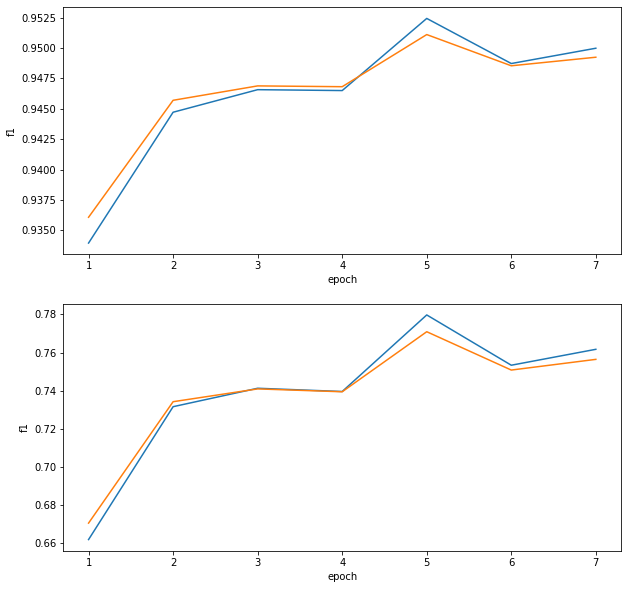

In [0]:
epochs = 7
for a in activations:
  print("activation - %s" %a)
  get_model("sum", [tf.keras.layers.Dense(50, activation=a)], "sigmoid", batch_size, epochs, 0)

Лучше всего себя показала функция "sidmoid" на 7 эпохе;  
результаты:  
- weighted f1 on train: ~0.955
- macro f1 on train: ~0.8
- weighted f1 on valid: ~0.955
- macro f1 on valid: ~0.8
При этом графики не расходятся, а сама функция растет

## Итог

Таким образом, лучше всего в плане результатов себя показало сложение векторов

# Использование одновременно двух эмбеддингов

In [0]:
import gensim
dim = 200
texts = quora.question_text.apply(preprocess).tolist()

In [0]:
ft = gensim.models.FastText(texts, size=dim, iter=2, window=3)

In [0]:
w2v = gensim.models.Word2Vec(texts, size=dim, window=3, min_count=1)

In [0]:
def get_weights(word2id, model):

  dim = model.vector_size
  weights = np.zeros((len(word2id), dim))

  for word, i in word2id.items():
    if word == 'PAD':
        continue
    if word == 'UNK':
        weights[i] = model.wv.get_vector("adopted") 
    try:
        weights[i] = model.wv.get_vector(word)
    except KeyError:
      weights[i] = model.wv.get_vector("adopted") 
  return weights

In [0]:
weights_ft = get_weights(word2id, ft)
weights_w2v = get_weights(word2id, w2v)

Epoch 1/5
249/249 [==============================] - 185s 743ms/step - loss: 0.1619 - accuracy: 0.9397 - val_loss: 0.1377 - val_accuracy: 0.9475
Epoch 2/5
249/249 [==============================] - 186s 748ms/step - loss: 0.1339 - accuracy: 0.9472 - val_loss: 0.1349 - val_accuracy: 0.9495
Epoch 3/5
249/249 [==============================] - 186s 748ms/step - loss: 0.1291 - accuracy: 0.9493 - val_loss: 0.1302 - val_accuracy: 0.9497
Epoch 4/5
249/249 [==============================] - 189s 759ms/step - loss: 0.1240 - accuracy: 0.9512 - val_loss: 0.1311 - val_accuracy: 0.9501
Epoch 5/5
249/249 [==============================] - 188s 757ms/step - loss: 0.1205 - accuracy: 0.9526 - val_loss: 0.1296 - val_accuracy: 0.9510
weighted f1 on train:  [0.9360672191729693, 0.9412593782874089, 0.9478281870693505, 0.9486424362855351, 0.9501536957136832]
macro f1 on train:  [0.6794332360344086, 0.7131259535096628, 0.7594311397723164, 0.7588506147104382, 0.7660553279555149]
weighted f1 on valid:  [0.9369

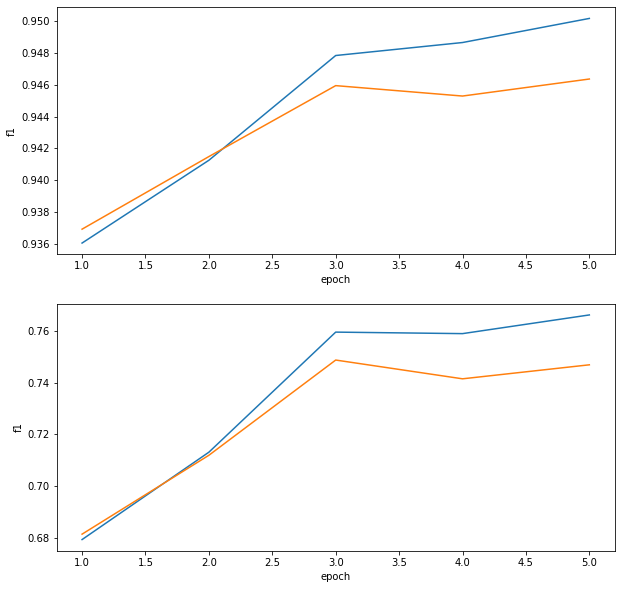

In [26]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings_ft = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, trainable=False, weights=[weights_ft])(inputs)
embeddings_w2v = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, trainable=False, weights=[weights_w2v])(inputs)
conc_emb = tf.keras.layers.Concatenate()([embeddings_ft, embeddings_w2v])

transformed = tf.keras.layers.Flatten()(conc_emb)
  
dense = tf.keras.layers.Dense(100, activation="relu")(transformed)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callbacks = My_Callbacks()
callbacks.clear()
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
          epochs=5,
          callbacks=[callbacks],
          verbose=1)
callbacks.show_scores()

plot_x = [e for e in range(1, 5+1)]

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(plot_x, callbacks.f1_w_train, label='weighted f1 train')
ax2.plot(plot_x, callbacks.f1_m_train, label='macro f1 train')
ax1.plot(plot_x, callbacks.f1_w_valid, label='weighted f1 valid')
ax2.plot(plot_x, callbacks.f1_m_valid, label='macro f1 valid')
ax1.set_ylabel('f1')
ax1.set_xlabel('epoch')
ax2.set_ylabel('f1')
ax2.set_xlabel('epoch')
fig.set_size_inches(10, 10, forward=True)
plt.show()

По итогу, результаты не особо изменились по сравнению с прошлыми моделями